# Data Analysis Notebok

This notebook is used to analyze the data generated during our numerical expeirments and to make plots.

In [1]:
## imports 
import tqdm
import os
import pickle
from collections import Counter
import itertools
import random
import numpy as np
from scipy.sparse import csr_array
import networkx as nx
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import qiskit
from qiskit.quantum_info import random_clifford, Clifford
from qiskit.synthesis import synth_clifford_full
from qiskit import Aer, execute, QuantumCircuit

import clifford as cl

In [2]:
## plotting imports and settings
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rc("font", family="serif", size=14)
# matplotlib.rc('text', usetex=True)
matplotlib.rc("legend", fontsize=14)
plt.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
## Set RNG
rng = np.random.default_rng(1337)

## Preliminaries

How does the size of the Clifford group scale with circuit width $n$ (qubits)?

In [4]:
for n in range(2, 7):
    print(f"n = {n}")
    print(f"  Move set size = {int(cl.size_movet_set(n))}")
    print(f"  Clifford group size = {np.exp(cl.clifford_log_dim(n)):.2e}")

n = 2
  Move set size = 15
  Clifford group size = 1.15e+04
n = 3
  Move set size = 27
  Clifford group size = 9.29e+07
n = 4
  Move set size = 42
  Clifford group size = 1.21e+13
n = 5
  Move set size = 60
  Clifford group size = 2.54e+19
n = 6
  Move set size = 81
  Clifford group size = 8.52e+26


Inspect a random sequence

In [5]:
cl.random_sequence(rng, 10, 3)

[(1, 2, 'swap'),
 (0, 'y'),
 (2, 'x'),
 (2, 'sdg'),
 (2, 'x'),
 (0, 'h'),
 (0, 's'),
 (1, 'sdg'),
 (1, 'y'),
 (2, 's')]

In [6]:
problem = cl.Problem(5, drop_phase_bits=True)


def build_candidates():
    return (
        np.einsum(
            "ij, mjk -> mik", 1 * problem.state.tableau[:, :-1], problem.move_set_array
        )
        % 2
    )


%timeit build_candidates()

156 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
problem = cl.Problem(5, drop_phase_bits=False)
candidates = [problem.state & tableau for tableau in problem.move_set_tableau.values()]


def build_candidates(candidates=None):
    if candidates is None:
        candidates = [
            problem.state & tableau for tableau in problem.move_set_tableau.values()
        ]
    return np.asarray([candidate.tableau for candidate in candidates])

In [8]:
%timeit build_candidates(candidates)

16.5 µs ± 382 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
%timeit build_candidates()

10.4 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Data Analysis

Analyze the data generated by running `clifford.py` for various circuit widths.

In [10]:
## make a figure directory
if not os.path.exists("figures"):
    os.makedirs("figures")

In [11]:
num_qubit_scaling_fn = {
    'log': lambda n : int(20 * np.log(n)/np.log(2)),
    'linear': lambda n : int(20 * n/2),    
    'log-linear': lambda n : int(10 * n * np.log(n)/np.log(2))
}

for n in range(2, 15):
    print(
        f"num_qubits={n}, Lmax (log) = {num_qubit_scaling_fn['log'](n)}" 
        + f"   Lmax (linear) = {num_qubit_scaling_fn['linear'](n)},   Lmax (log-inear) = {num_qubit_scaling_fn['log-linear'](n)}"
        )

num_qubits=2, Lmax (log) = 20   Lmax (linear) = 20,   Lmax (log-inear) = 20
num_qubits=3, Lmax (log) = 31   Lmax (linear) = 30,   Lmax (log-inear) = 47
num_qubits=4, Lmax (log) = 40   Lmax (linear) = 40,   Lmax (log-inear) = 80
num_qubits=5, Lmax (log) = 46   Lmax (linear) = 50,   Lmax (log-inear) = 116
num_qubits=6, Lmax (log) = 51   Lmax (linear) = 60,   Lmax (log-inear) = 155
num_qubits=7, Lmax (log) = 56   Lmax (linear) = 70,   Lmax (log-inear) = 196
num_qubits=8, Lmax (log) = 60   Lmax (linear) = 80,   Lmax (log-inear) = 240
num_qubits=9, Lmax (log) = 63   Lmax (linear) = 90,   Lmax (log-inear) = 285
num_qubits=10, Lmax (log) = 66   Lmax (linear) = 100,   Lmax (log-inear) = 332
num_qubits=11, Lmax (log) = 69   Lmax (linear) = 110,   Lmax (log-inear) = 380
num_qubits=12, Lmax (log) = 71   Lmax (linear) = 120,   Lmax (log-inear) = 430
num_qubits=13, Lmax (log) = 74   Lmax (linear) = 130,   Lmax (log-inear) = 481
num_qubits=14, Lmax (log) = 76   Lmax (linear) = 140,   Lmax (log-inear

In [12]:
## build a dictionary of data directories for the different values of n and scaling
drop_phase_bits = True
scaling = 'log-linear'
data_dirs = {}

for scaling in ['linear', 'log-linear']:
    num_qubit_list= [n for n in range(3, 13)]
    if drop_phase_bits:
        data_dirs[scaling] = {n : f'data_n_{n}_drop_phase_bits_scaling_{scaling}' for n in num_qubit_list}
    else:
        data_dirs[scaling] = {n : f'data_n_{n}_high{fn(n)}' for n in num_qubit_list}

print(data_dirs)

{'linear': {3: 'data_n_3_drop_phase_bits_scaling_linear', 4: 'data_n_4_drop_phase_bits_scaling_linear', 5: 'data_n_5_drop_phase_bits_scaling_linear', 6: 'data_n_6_drop_phase_bits_scaling_linear', 7: 'data_n_7_drop_phase_bits_scaling_linear', 8: 'data_n_8_drop_phase_bits_scaling_linear', 9: 'data_n_9_drop_phase_bits_scaling_linear', 10: 'data_n_10_drop_phase_bits_scaling_linear', 11: 'data_n_11_drop_phase_bits_scaling_linear', 12: 'data_n_12_drop_phase_bits_scaling_linear'}, 'log-linear': {3: 'data_n_3_drop_phase_bits_scaling_log-linear', 4: 'data_n_4_drop_phase_bits_scaling_log-linear', 5: 'data_n_5_drop_phase_bits_scaling_log-linear', 6: 'data_n_6_drop_phase_bits_scaling_log-linear', 7: 'data_n_7_drop_phase_bits_scaling_log-linear', 8: 'data_n_8_drop_phase_bits_scaling_log-linear', 9: 'data_n_9_drop_phase_bits_scaling_log-linear', 10: 'data_n_10_drop_phase_bits_scaling_log-linear', 11: 'data_n_11_drop_phase_bits_scaling_log-linear', 12: 'data_n_12_drop_phase_bits_scaling_log-linear'}}

Examine the loss, both throughout training and the final value.

/tmp/ipykernel_65888/221901519.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap


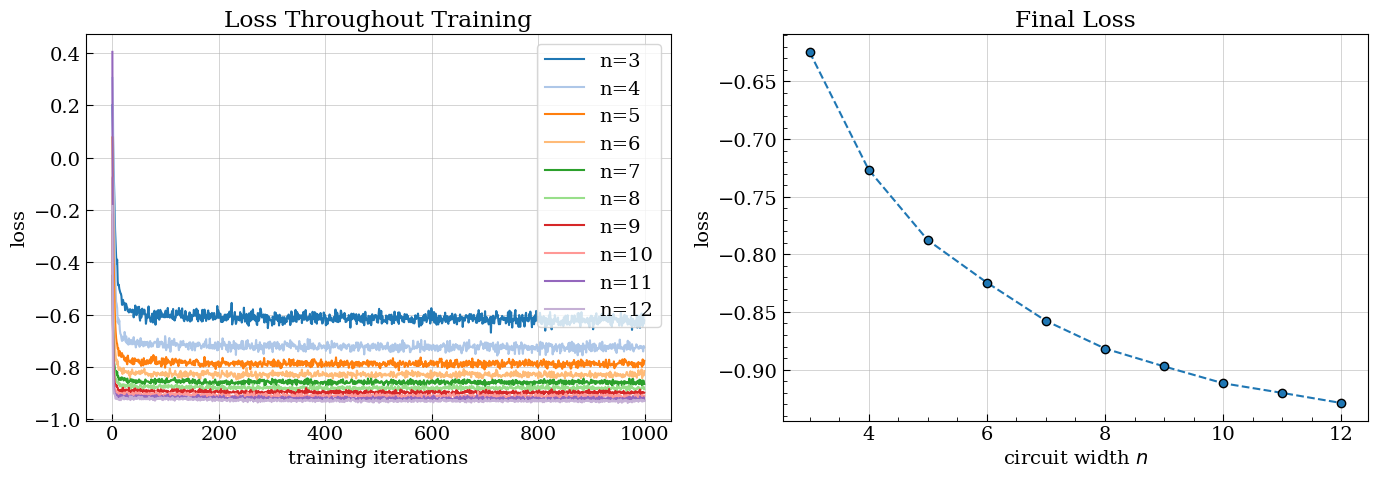

In [13]:
## use a different color scheme to plot a large number of curves
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors_tab = cmap.colors  # type: list

fig, ax = plt.subplots(1, 2, figsize=(2 * 7, 5))
[ax[i].set_prop_cycle(color=colors_tab) for i in range(len(ax))]

final_loss_list = []
for num_qubits in num_qubit_list:
    loss_history = np.load("data/" + data_dirs[scaling][num_qubits] + "/loss_history.npy")
    ax[0].plot(np.asarray(loss_history), label=f"n={num_qubits}")
    final_loss_list.append(np.mean(loss_history[-10:]))

ax[0].set_xlabel("training iterations")
ax[0].set_ylabel("loss")
ax[0].set_title("Loss Throughout Training")
ax[0].legend()  # bbox_to_anchor=(-0.2, 1))

ax[1].plot(num_qubit_list, final_loss_list, "--o", markeredgecolor="k")
ax[1].set_xlabel(r"circuit width $n$")
ax[1].set_ylabel("loss")
ax[1].set_title("Final Loss")

plt.minorticks_on()
plt.tight_layout()
plt.savefig("figures/training_history.png")

plt.show()

Make a nice plot of the final loss

/tmp/ipykernel_65888/3296459750.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


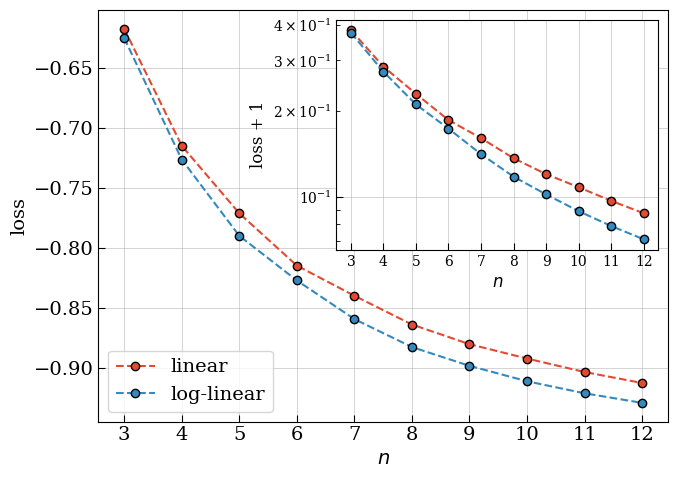

In [14]:
fig, ax = plt.subplots( figsize=(7, 5))

axinset = inset_axes(ax, width=2.3*7/5, height=2.3)
axinset.tick_params(axis='both', which='both', labelsize=10)

for scaling in ['linear', 'log-linear']:

    final_loss_list = []
    for num_qubits in num_qubit_list:
        loss_history = np.load("data/" + data_dirs[scaling][num_qubits] + "/loss_history.npy")
        final_loss_list.append(np.mean(loss_history[-20:]))
    final_loss_list = np.asarray(final_loss_list)

    ax.plot(num_qubit_list, final_loss_list, "--o", markeredgecolor="k", label=scaling)
    axinset.plot(num_qubit_list, 1 + final_loss_list, "--o", markeredgecolor="k", label=scaling)

ax.set_xlabel(r"$n$")
ax.set_ylabel("loss")
#ax.set_title("Final Loss")
ax.legend(loc='lower left')
ax.set_xticks(np.arange(3, len(num_qubit_list) + 3))

axinset.set_xlabel(r"$n$", fontsize=12)
axinset.set_ylabel("loss + 1", fontsize=12)
axinset.set_yscale('log')
#aaxinsetx.legend()
axinset.set_xticks(np.arange(3, len(num_qubit_list) + 3))

#plt.minorticks_on()
plt.tight_layout()
plt.savefig("figures/final_training_loss.png")

plt.show()

Make a plot of the cumulative fraction of instances solved 

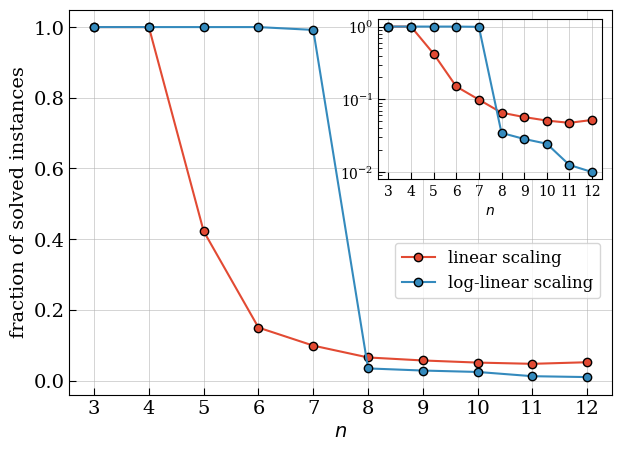

In [15]:
eval_max_iter = 1000

fig, ax = plt.subplots(figsize=(7, 5))
axinset = inset_axes(ax, width=1.6*7/5, height=1.6)
axinset.tick_params(axis='both', which='both', labelsize=10)

for scaling in ['linear', 'log-linear']:

    fraction_of_solved_instances = []
    for i, num_qubits in enumerate(num_qubit_list):
        with open(f"data/" + data_dirs[scaling][num_qubits] + f"/eval/steps_until_success_eval_max_iter_{eval_max_iter}.pkl", "rb") as f:
            steps_until_success = pickle.load(f)

        fraction_of_solved_instances.append(
            len([x for x in steps_until_success["lgf"]["weighted_steps"] if x is not None])
            / len(steps_until_success["lgf"]["weighted_steps"])
        )

    ax.plot(num_qubit_list, fraction_of_solved_instances, "-o", markeredgecolor="k", label=f"{scaling} scaling")

    axinset.plot(num_qubit_list, fraction_of_solved_instances, "-o", markeredgecolor="k", label=f"{scaling} scaling")

ax.legend(loc=(0.6, 0.25), fontsize=12)
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"fraction of solved instances")
ax.set_xticks(np.arange(3, len(num_qubit_list) + 3))

axinset.set_xlabel(r"$n$", fontsize=10)
#axinset.set_ylabel(r"fraction of solved instances")
axinset.set_yscale('log')
axinset.set_xticks(np.arange(3, len(num_qubit_list) + 3))

plt.savefig("figures/fraction_solved_instances.png")

plt.show()

Show the results for the LGF greedy algorithm.

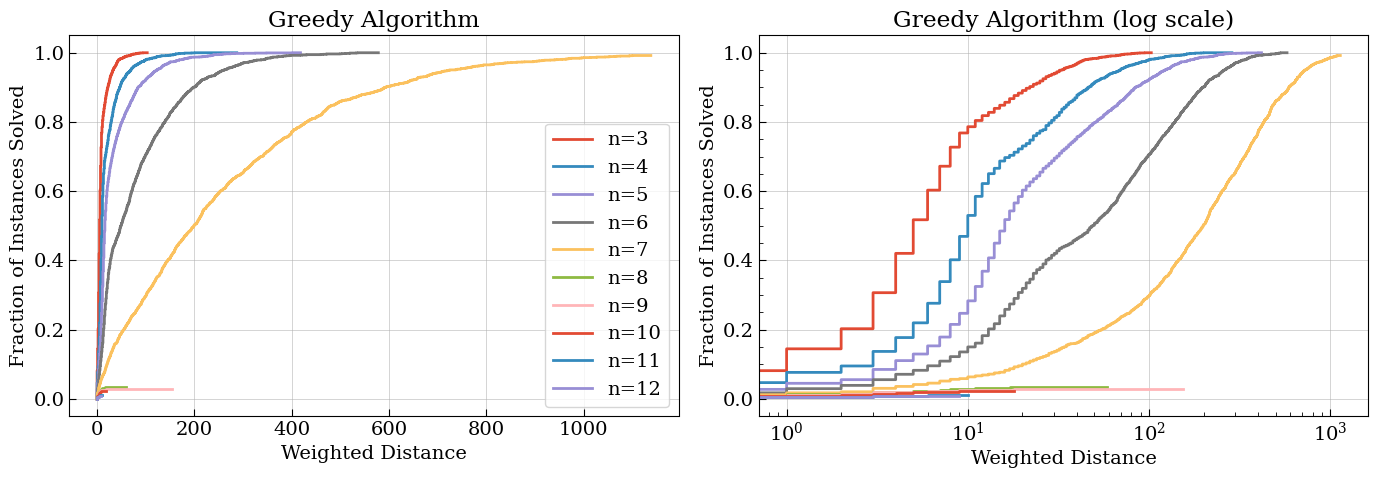

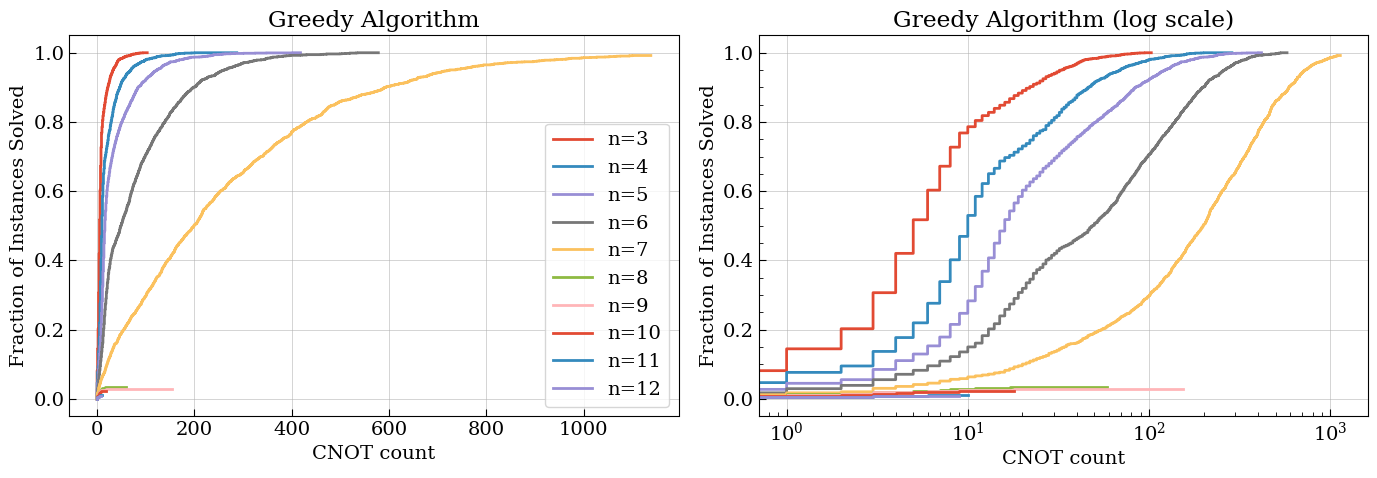

In [17]:
scaling = 'log-linear'

xlabel_dict = {"weighted_steps": "Weighted Distance", "CNOTs": "CNOT count"}
for metric, xlabel in xlabel_dict.items():
    fig, ax = plt.subplots(1, 2, figsize=(2 * 7, 5))
    # ax[0].set_prop_cycle(color=colors)
    # ax[1].set_prop_cycle(color=colors)

    for i, num_qubits in enumerate(num_qubit_list):
        with open(
            f"data/" + data_dirs[scaling][num_qubits] + f"/eval/steps_until_success_eval_max_iter_{eval_max_iter}.pkl", "rb"
        ) as f:
            steps_until_success = pickle.load(f)

        cum_steps_utils_success_lgf = np.sort(
            [n for n in steps_until_success["lgf"][metric] if n is not None]
        )

        ax[0].step(
            cum_steps_utils_success_lgf,
            np.arange(len(cum_steps_utils_success_lgf))
            / len(steps_until_success["lgf"][metric]),
            label=f"n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )
        ax[1].step(
            cum_steps_utils_success_lgf,
            np.arange(len(cum_steps_utils_success_lgf))
            / len(steps_until_success["lgf"][metric]),
            label=f"n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )

    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel("Fraction of Instances Solved")
    ax[0].legend()
    ax[0].set_title("Greedy Algorithm")

    ax[1].set_xscale("log")
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel("Fraction of Instances Solved")
    ax[1].set_title("Greedy Algorithm (log scale)")

    plt.minorticks_on()
    plt.tight_layout()

    plt.show()

Now add in the comparison with the built-in Qiskit method.

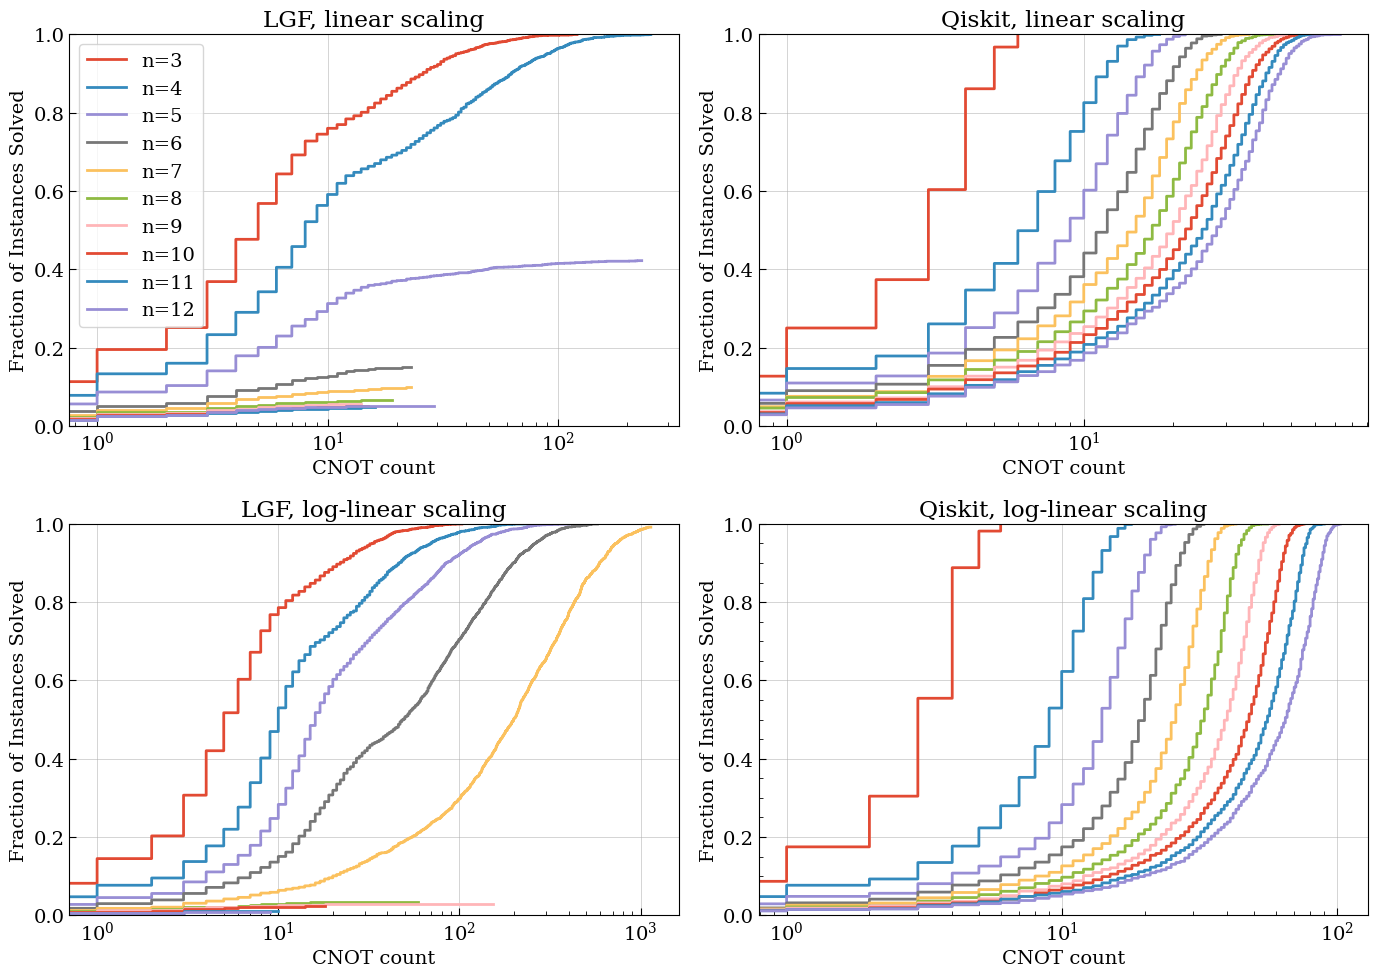

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(2 * 7, 2 * 5))
ax = ax.flatten()

for i_scaling, scaling in enumerate(['linear', 'log-linear']):

    metric = 'CNOTs'

    for i, num_qubits in enumerate(num_qubit_list):
        with open(
            f"data/" + data_dirs[scaling][num_qubits] + f"/eval/steps_until_success_eval_max_iter_{eval_max_iter}.pkl", "rb"
        ) as f:
            steps_until_success = pickle.load(f)

        cum_steps_utils_success_lgf = np.sort(
            [n for n in steps_until_success["lgf"][metric] if n is not None]
        )
        cum_steps_utils_success_qiskit = np.sort(
            [n for n in steps_until_success["qiskit"][metric] if n is not None]
        )

        ax[2 * i_scaling].step(
            cum_steps_utils_success_lgf,
            np.arange(len(cum_steps_utils_success_lgf))
            / len(steps_until_success["lgf"][metric]),
            label=f"n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )
        ax[2 * i_scaling + 1].step(
            cum_steps_utils_success_qiskit,
            np.arange(len(cum_steps_utils_success_qiskit))
            / len(steps_until_success["qiskit"][metric]),
            label=f"qiskit n={num_qubits}",
            linewidth=2,
            alpha=1.0,
            linestyle="-",
            #color=colors[i],
        )

    ax[2 * i_scaling].set_xscale("log")
    ax[2 * i_scaling].set_xlabel(xlabel)
    ax[2 * i_scaling].set_ylabel("Fraction of Instances Solved")
    ax[2 * i_scaling].set_title(f"LGF, {scaling} scaling")
    #ax[2 * i_scaling].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[2 * i_scaling].set_ylim([0, 1])

    ax[2 * i_scaling + 1].set_xscale("log")
    ax[2 * i_scaling + 1].set_xlabel(xlabel)
    ax[2 * i_scaling + 1].set_ylabel("Fraction of Instances Solved")
    ax[2 * i_scaling + 1].set_title(f"Qiskit, {scaling} scaling")
    #ax[2 * i_scaling].set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
    ax[2 * i_scaling + 1].set_ylim([0, 1])

ax[0].legend()
plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"figures/cumulative_plot.png")
plt.show()

In [19]:
style_dict = {'linear':'-', 'log-linear':'--'}

for metric, xlabel in xlabel_dict.items():
    
    print(f'Plotting {xlabel}')

    fig, ax = plt.subplots(2, 5, figsize=(5 * 7, 2 * 5), dpi=600)
    ax = ax.flatten()

    # loop over all scalings
    for i_scaling, scaling in enumerate(['linear', 'log-linear']):

        ## loop over all circuit widths
        for i, num_qubits in enumerate(num_qubit_list):
                
            with open(
                f"data/" + data_dirs[scaling][num_qubits] + f"/eval/steps_until_success_eval_max_iter_{eval_max_iter}.pkl", "rb"
            ) as f:
                steps_until_success = pickle.load(f)

            cum_steps_utils_success_lgf = np.sort(
                [n for n in steps_until_success["lgf"][metric] if n is not None]
            )
            # cum_steps_utils_success_random = np.sort([n for n in steps_until_success['random'] if n is not None])
            cum_steps_utils_success_qiskit = np.sort(
                [n for n in steps_until_success["qiskit"][metric] if n is not None]
            )

            ax[i].step(
                cum_steps_utils_success_qiskit,
                np.arange(len(cum_steps_utils_success_qiskit))
                / len(steps_until_success["qiskit"][metric]),
                label=f"Qiskit ({scaling})",
                linewidth=2,
                alpha=1.0,
                linestyle=style_dict[scaling],
                color=colors[0],
            )
            ax[i].step(
                cum_steps_utils_success_lgf,
                np.arange(len(cum_steps_utils_success_lgf))
                / len(steps_until_success["lgf"][metric]),
                label=f"LGF ({scaling})",
                linewidth=2,
                alpha=1.0,
                linestyle=style_dict[scaling],
                color=colors[1],
            )

            ax[i].set_title(f"n = {num_qubits}", fontsize=18)
            ax[i].set_xscale("log")
            #ax[i].legend()
            # ax.set_xlim([1, max(ax[0].get_xlim()[1], ax[1].get_xlim()[1])])
            ax[i].set_ylim([0, 1])

            if i >= 5:
                ax[i].set_xlabel(xlabel, fontsize=18)
            if i in [0, 5]:
                ax[i].set_ylabel("Fraction of Instances Solved")

    handles,labels = ax[0].get_legend_handles_labels()
    handles = [handles[0], handles[2], handles[1], handles[3]]
    labels = [labels[0], labels[2], labels[1], labels[3]]
    ax[0].legend(handles,labels)

    plt.minorticks_on()
    plt.tight_layout()
    plt.savefig(f"figures/cumulative_plot_comparison_{metric}.png")
    plt.show()

Plotting Weighted Distance


Plotting CNOT count


Extract the conditional statistics (conditional here means that the LGF algorithm terminated successfully).

In [34]:
steps_until_success_conditional = {
    "qiskit" : {scaling: {metric: {n:[] for n in num_qubit_list} for metric in ["CNOTs", "weighted_steps"]} for scaling in ['linear', 'log-linear']},
    "lgf" : {scaling: {metric: {n:[] for n in num_qubit_list} for metric in ["CNOTs", "weighted_steps"]} for scaling in ['linear', 'log-linear']},
    }

# loop over scaling
for scaling in ['linear', 'log-linear']:
    
    # loop over metric
    for metric in ["CNOTs", "weighted_steps"]:

        # loop over num_qubits
        for num_qubits in num_qubit_list:
            
            # load
            with open(f"data/" + data_dirs[scaling][num_qubits] + f"/eval/steps_until_success_eval_max_iter_{eval_max_iter}.pkl", "rb") as f:
                steps_until_success = pickle.load(f)

            # loop over all iterations in an evaluation run
            for steps_qiskit, steps_lgf in zip(steps_until_success["qiskit"][metric], steps_until_success["lgf"][metric]):
            
                # condition on instances where the LGF approach terminates    
                if steps_lgf is not None:
                    steps_until_success_conditional["qiskit"][scaling][metric][num_qubits].append(steps_qiskit)
                    steps_until_success_conditional["lgf"][scaling][metric][num_qubits].append(steps_lgf)
                    
            # convert to numpy array
            steps_until_success_conditional["qiskit"][scaling][metric][num_qubits] = np.asarray(steps_until_success_conditional["qiskit"][scaling][metric][num_qubits])
            steps_until_success_conditional["lgf"][scaling][metric][num_qubits] = np.asarray(steps_until_success_conditional["lgf"][scaling][metric][num_qubits])

In [46]:
for scaling in ['linear', 'log-linear']:
    for metric in ["CNOTs", "weighted_steps"]:

        print(f"\nscaling={scaling}, metric={metric}")

        for num_qubits in num_qubit_list:

            delta = steps_until_success_conditional["qiskit"][scaling][metric][num_qubits] - steps_until_success_conditional["lgf"][scaling][metric][num_qubits]
            
            print(f"  n={num_qubits}, LGF beats Qiskit {np.mean(delta > 0):.4f} fraction of the time")


scaling=linear, metric=CNOTs
  n=3, LGF beats Qiskit 0.0000 fraction of the time
  n=4, LGF beats Qiskit 0.1875 fraction of the time
  n=5, LGF beats Qiskit 0.2178 fraction of the time
  n=6, LGF beats Qiskit 0.2167 fraction of the time
  n=7, LGF beats Qiskit 0.1364 fraction of the time
  n=8, LGF beats Qiskit 0.0840 fraction of the time
  n=9, LGF beats Qiskit 0.0351 fraction of the time
  n=10, LGF beats Qiskit 0.0490 fraction of the time
  n=11, LGF beats Qiskit 0.0632 fraction of the time
  n=12, LGF beats Qiskit 0.0385 fraction of the time

scaling=linear, metric=weighted_steps
  n=3, LGF beats Qiskit 0.0000 fraction of the time
  n=4, LGF beats Qiskit 0.1875 fraction of the time
  n=5, LGF beats Qiskit 0.2178 fraction of the time
  n=6, LGF beats Qiskit 0.2167 fraction of the time
  n=7, LGF beats Qiskit 0.1364 fraction of the time
  n=8, LGF beats Qiskit 0.0840 fraction of the time
  n=9, LGF beats Qiskit 0.0351 fraction of the time
  n=10, LGF beats Qiskit 0.0490 fraction of 

In [47]:
for scaling in ['linear', 'log-linear']:
    for metric in ["CNOTs", "weighted_steps"]:

        print(f"\nscaling={scaling}, metric={metric}")

        for num_qubits in num_qubit_list:

            delta = steps_until_success_conditional["qiskit"][scaling][metric][num_qubits] - steps_until_success_conditional["lgf"][scaling][metric][num_qubits]
            
            print(f"  n={num_qubits}, LGF beats or matches Qiskit {np.mean(delta >= 0):.4f} fraction of the time")


scaling=linear, metric=CNOTs
  n=3, LGF beats or matches Qiskit 0.4710 fraction of the time
  n=4, LGF beats or matches Qiskit 0.5900 fraction of the time
  n=5, LGF beats or matches Qiskit 0.8000 fraction of the time
  n=6, LGF beats or matches Qiskit 0.9900 fraction of the time
  n=7, LGF beats or matches Qiskit 0.9848 fraction of the time
  n=8, LGF beats or matches Qiskit 1.0000 fraction of the time
  n=9, LGF beats or matches Qiskit 0.9912 fraction of the time
  n=10, LGF beats or matches Qiskit 0.9902 fraction of the time
  n=11, LGF beats or matches Qiskit 1.0000 fraction of the time
  n=12, LGF beats or matches Qiskit 0.9904 fraction of the time

scaling=linear, metric=weighted_steps
  n=3, LGF beats or matches Qiskit 0.4710 fraction of the time
  n=4, LGF beats or matches Qiskit 0.5900 fraction of the time
  n=5, LGF beats or matches Qiskit 0.8000 fraction of the time
  n=6, LGF beats or matches Qiskit 0.9900 fraction of the time
  n=7, LGF beats or matches Qiskit 0.9848 frac

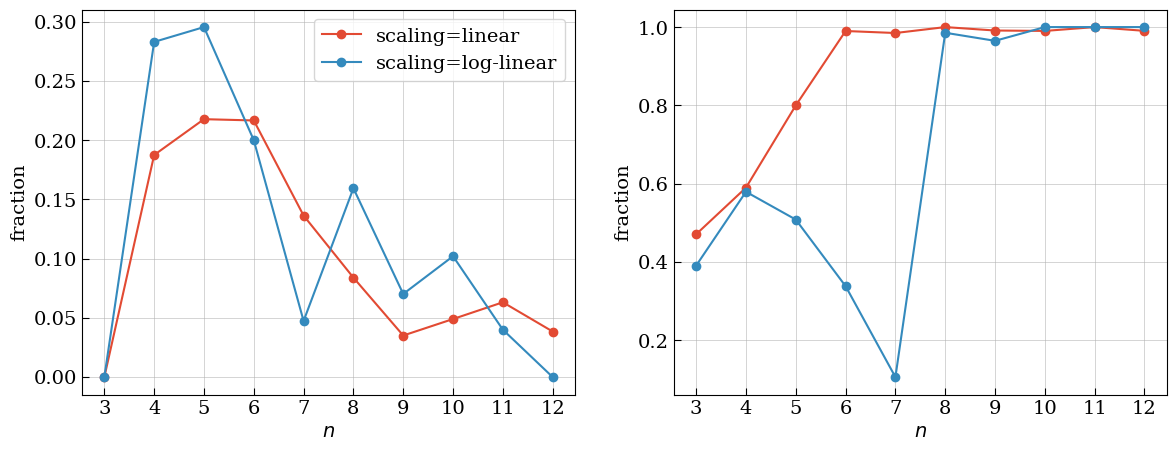

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 7, 5)) #dpi=600)
ax = ax.flatten()

for scaling in ['linear', 'log-linear']:
    for metric in ["CNOTs"]: #, "weighted_steps"]:
        
        beats = [
            np.mean(
                steps_until_success_conditional["qiskit"][scaling][metric][num_qubits] - steps_until_success_conditional["lgf"][scaling][metric][num_qubits] > 0) 
            for num_qubits in num_qubit_list]
        
        ax[0].plot(num_qubit_list, beats, '-o', label=f"scaling={scaling}") #, metric={metric}")

        beats_or_matches = [
            np.mean(
                steps_until_success_conditional["qiskit"][scaling][metric][num_qubits] - steps_until_success_conditional["lgf"][scaling][metric][num_qubits] >= 0) 
            for num_qubits in num_qubit_list]
        
        ax[1].plot(num_qubit_list, beats_or_matches, '-o')     

ax[0].set_xlabel(r"$n$", fontsize=14)
ax[0].set_ylabel(r"fraction", fontsize=14)
ax[0].set_xticks(np.arange(3, len(num_qubit_list) + 3))

ax[1].set_xlabel(r"$n$", fontsize=14)
ax[1].set_ylabel(r"fraction", fontsize=14)
ax[1].set_xticks(np.arange(3, len(num_qubit_list) + 3))

#ax.set_title("Fraction of instances where LGF beats Qiskit, conditioned on LGF terminating")
ax[0].legend()

plt.show()

TO DELETE

In [ ]:
       steps_utils_success_lgf = np.asarray(
            [x for x in steps_until_success["lgf"][metric] if x is not None]
        )
        steps_utils_success_qiskit = np.asarray(
            [
                x_qiskit
                for x_qiskit, x_lgf in zip(steps_until_success["qiskit"][metric], steps_until_success["lgf"][metric]) if x_lgf is not None
            ]
        )

        print(
            f"(n={num_qubits}): fraction of instances where lgf method beats qiskit: %.4f"
            % np.mean(steps_utils_success_qiskit > steps_utils_success_lgf)
        )

        print(
            f"(n={num_qubits}): fraction of instances where lgf method beats or matches qiskit: %.4f\n"
            % np.mean(steps_utils_success_qiskit >= steps_utils_success_lgf)
        )

How good is the LGF method at reducing the CNOT count?

In [ ]:

    print(len(steps_utils_success_qiskit))

    for i in range(len(steps_until_success["lgf"][metric])):
        if steps_until_success["lgf"][metric][i] is not None:
            if (
                steps_until_success["lgf"][metric][i]
                < steps_until_success["qiskit"][metric][i]
            ):
                ratio = -(
                    steps_until_success["lgf"][metric][i]
                    - steps_until_success["qiskit"][metric][i]
                )  # / steps_until_success['qiskit'][i]
                ratio_improvement[num_qubits].append(ratio)
            elif (
                steps_until_success["lgf"][metric][i]
                > steps_until_success["qiskit"][metric][i]
            ):
                ratio = (
                    steps_until_success["lgf"][metric][i]
                    - steps_until_success["qiskit"][metric][i]
                )  # / steps_until_success['qiskit'][i]
                ratio_worsen[num_qubits].append(ratio)

In [ ]:
[np.median(ratio_improvement[n]) for n in num_qubit_list[1:]]

In [ ]:
[np.mean(ratio_improvement[n]) for n in num_qubit_list[1:]]

In [ ]:
plt.hist(ratio_improvement[5])

Am I only beating Qiskit because I'm not worrying about the phase bits but they are? So their decomp requires more gates? See if I can do it with less cx and swap gates specifically.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 7, 5))

for i, n in enumerate(num_qubit_list):
    ax[0].hist(
        ratio_improvement[n],
        50,
        label=f"n={n}",
        density=True,
        alpha=1,
        histtype="step",
        linewidth=3,
        color=colors[i],
    )
    ax[0].legend()
    ax[0].set_title("Fractional Improvement Us vs Qiskit")

    ax[1].hist(
        ratio_worsen[n],
        20,
        label=f"n={n}",
        density=True,
        alpha=1,
        histtype="step",
        linewidth=3,
        color=colors[i],
    )
    ax[1].legend()
    ax[1].set_title("Fractional Improvement Qiskit vs Us")
    # ax[1].set_xlim([0,200])

plt.show()

In [ ]:
ratio_improvement

In [ ]:
ratio_worsen

Analyze the effect of the random seeds on the success/probability of the hillclimbing algorithm.

In [ ]:
num_qubits = 4
data_dir = f"data/data_n_{num_qubits}/"

lgf_model = cl.LGFModel(
    num_qubits=num_qubits,
    device=device,
    rng=rng,
    drop_phase_bit=True,
    hidden_layers=[32, 16, 4],
)

checkpoint = torch.load(data_dir + "checkpoint")
lgf_model.load_state_dict(checkpoint)

In [ ]:
with open(data_dir + "args.pkl", "rb") as f:
    x = pickle.load(f)
x

In [ ]:
max_iter = 1000
num_initial_state_trials = 100
num_hillclimb_trials = 100
success_matrix = np.zeros((num_initial_state_trials, num_hillclimb_trials))

## loop over initial states
for initial_seed in range(num_initial_state_trials):
    problem = cl.Problem(lgf_model.num_qubits, seed=initial_seed)
    success_count = 0.0

    ## loop over hillclimbing seeds
    pbar = tqdm.trange(num_hillclimb_trials)
    for hillclimbing_seed in pbar:
        result = cl.hillclimbing(
            problem.state,
            lgf_model,
            max_iter=max_iter,
            seed=hillclimbing_seed,
        )

        success_matrix[initial_seed, hillclimbing_seed] = result["success"] * 1.0
        success_count += result["success"] * 1.0
        pbar.set_description(
            "success rate=%.4f" % (success_count / (hillclimbing_seed + 1))
        )

In [ ]:
## average over initial state seeds
## each entry is a different hillclimbing seed
np.mean(success_matrix, axis=0)

In [ ]:
## average over hillclimbing seeds
## each entry is a different initial seed
np.mean(success_matrix, axis=1)

In [ ]:
def relative_weight_x_to_cx(fidelity_x, fidelity_cx):
    """
    How many x gates are equivalent to a single cx gate,
    in terms of fidelity reduction?
    """
    return np.log(fidelity_cx) / np.log(fidelity_x)


relative_weight_x_to_cx(1 - 2.556e-4, 1 - 9.263e-3)

In [ ]:
weight_dict = {"x": 1, "y": 1, "z": 1, "h": 1, "s": 1, "sdg": 1, "cx": 30, "swap": 90}
# cl.normalize_dict(weight_dict)
weight_dict